This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pydelfi.score as score

tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

In [3]:
# we define a few hyper parameters here
np.random.seed(13)
n = 1000 # total number of data points for NF
n_sims = 2500  # total number of points for drawing posterior
n_class = 1 # number of different cosmologies for the training

In [4]:
# in order to perform the compressions, we need a few things
n_vec = 49
q_fid = [0.5, 0.7*np.sqrt(0.5/0.3)]
mul_mode_fac = 10. # factor multiplied to k and divided in theta to shrink error bars
Cl_fid = np.loadtxt('./power_spectra/der_power_spectrum_0.dat')[2:, 1] # at the fiducial value
mu = np.asarray(Cl_fid)
Cinv = mul_mode_fac*(2*np.arange(n_vec)+1) * np.eye(n_vec)/ (2*Cl_fid**2)
# now with the derivatives
mu_p1 = np.loadtxt('./power_spectra/der_power_spectrum_1.dat')[2:, 1]
mu_p2 = np.loadtxt('./power_spectra/der_power_spectrum_2.dat')[2:, 1]
h = 0.01
dmudt = np.zeros([2, n_vec])
dmudt[0] = (mu_p1 - mu)/h
dmudt[1] = (mu_p2 - mu)/h
#dmudt = np.reshape(dmudt, [2, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [5]:
Cinv

array([[3.04012998e+17, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.37107766e+18, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.05482464e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.29669932e+23, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.76843092e+23, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.28464187e+23]])

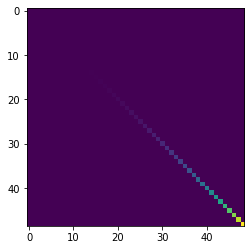

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(Cinv)
#ax[1].imshow(Cinv_)

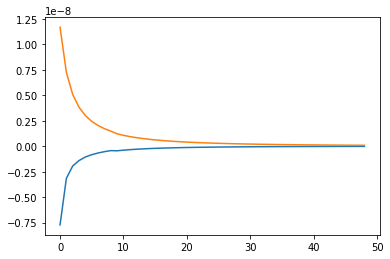

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(np.arange(n_vec), dmudt[0])
ax.plot(np.arange(n_vec), dmudt[1])

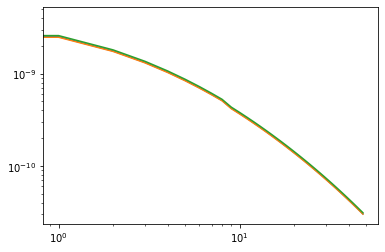

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.loglog(np.arange(n_vec), mu)
ax.loglog(np.arange(n_vec), mu_p1)
ax.loglog(np.arange(n_vec), mu_p2);

In [9]:
#print(mu, mu_p1, mu_p2)

In [10]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
#q_fid = q_fid  # new observation, different from the compression
np.random.seed(13)
lmax = 50
#obs_idx = 500
#q_obs = np.loadtxt('./power_spectra/parameters_rep_wider.txt')[obs_idx]
#d_vec_obs = np.loadtxt(f'./power_spectra/power_spectrum_{obs_idx}.dat')[2:, 1]
#d_vec_obs = np.reshape(d_vec_obs, [1, -1])
q_obs = np.loadtxt('./power_spectra/parameters_rep_wider.txt')[1000] #[0.5, 0.7*np.sqrt(0.5/0.3)] #np.loadtxt('./power_spectra/parameters_rep_wider.txt')[1000]
d_vec_obs = np.zeros((1, n_vec)) 
for index in range(1):
    load = np.loadtxt('./power_spectra/power_spectrum_1000.dat') #np.loadtxt('./power_spectra/der_power_spectrum_0.dat') #np.loadtxt('./power_spectra/power_spectrum_1000.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = mul_mode_fac*(2*ell+1)/2
        location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        single.append(np.random.gamma(shape, location))
    d_vec_obs[index] = single
d_vec_obs = load[2:, 1]
d_vec_obs = np.reshape(d_vec_obs, [1, -1])

# we also create the data corresponding to a fixed noise, but different q
d_vec_q = np.zeros((n_sims, n_vec))
n_bins = 50
xx = np.linspace(0.15, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)
yy = np.linspace(0.55, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)
index = 0
q_prior = np.zeros((n_bins*n_bins, 2))
for i in xx:
    for j in yy:
        load = np.loadtxt(f'./power_spectra/power_spectrum_{i}_{j}.dat')
        cls = load[:, 1]
        single = []
        for ell in range(2, lmax+1):
            shape = mul_mode_fac*(2*ell+1)/2
            location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
            np.random.seed(ell)
            single.append(np.random.gamma(shape, location))
        d_vec_q[index] = single
        q_prior[index, :] = i, j
        index += 1
    
d_vec_obs_keep = np.copy(d_vec_obs)
print(d_vec_q.shape, d_vec_obs.shape)

(2500, 49) (1, 49)


In [11]:
d_vec_obs

array([[2.20988324e-09, 1.39308811e-09, 9.83102681e-10, 7.42816198e-10,
        5.86937767e-10, 4.78653885e-10, 3.99625846e-10, 3.39831272e-10,
        2.93242857e-10, 2.36417106e-10, 2.07638019e-10, 1.83943079e-10,
        1.64171592e-10, 1.47481596e-10, 1.33249374e-10, 1.21004155e-10,
        1.10340251e-10, 1.01109375e-10, 9.29526293e-11, 8.57481505e-11,
        7.93328652e-11, 7.36226805e-11, 6.84882937e-11, 6.38725126e-11,
        5.96953017e-11, 5.59091084e-11, 5.24510612e-11, 4.93051897e-11,
        4.64393545e-11, 4.37970253e-11, 4.13658119e-11, 3.91296830e-11,
        3.70586723e-11, 3.51430540e-11, 3.33683009e-11, 3.17122756e-11,
        3.01713136e-11, 2.87410911e-11, 2.74086747e-11, 2.61571732e-11,
        2.49833310e-11, 2.38843891e-11, 2.28527942e-11, 2.18789969e-11,
        2.09617494e-11, 2.01002327e-11, 1.92909451e-11, 1.85275014e-11,
        1.78026125e-11]])

In [12]:
# we create here the data to compress and to feed to the NF
d_vec = np.zeros((n, n_vec))
lmax = 50
for index in range(n):
    load = np.loadtxt(f'./power_spectra/der_power_spectrum_0.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = mul_mode_fac*(2*ell+1)/2
        location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        single.append(np.random.gamma(shape, location))
    d_vec[index] = single
    
# we create here the data to compress and to feed to the NF
d_vec_keep_copy = np.zeros((n, n_vec))
obs_idx = 300
for index in range(n):
    load = np.loadtxt(f'./power_spectra/power_spectrum_{obs_idx}.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = mul_mode_fac*(2*ell+1)/2
        location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        single.append(np.random.gamma(shape, location))
    d_vec_keep_copy[index] = single

# we also create the data corresponding to fixed noise, at the fiducial q
d_vec_q_shift = np.zeros((1, n_vec))
for index in range(1):
    load = np.loadtxt('./power_spectra/der_power_spectrum_0.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = mul_mode_fac*(2*ell+1)/2
        location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        np.random.seed(ell)
        single.append(np.random.gamma(shape, location))
    d_vec_q_shift[index] = single

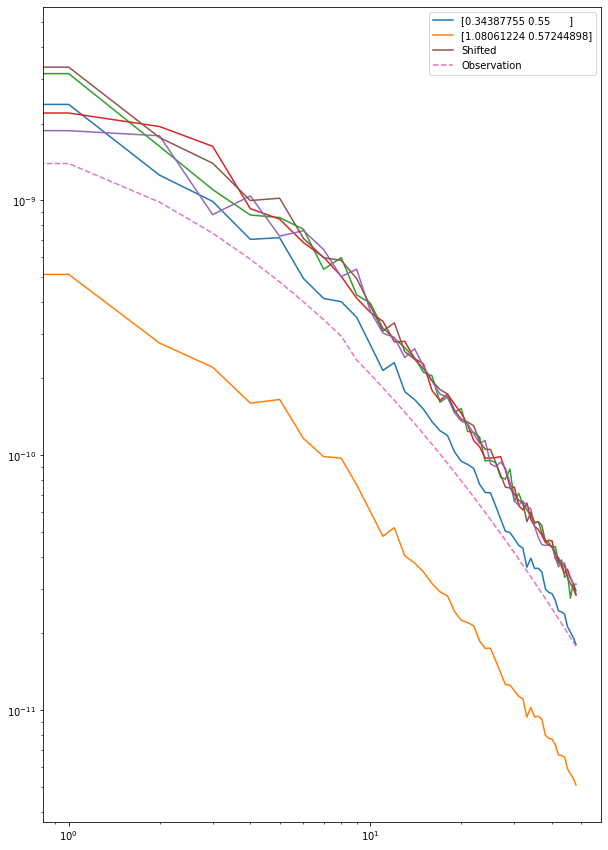

In [13]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in [500, 2402]:
    plt.loglog(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
    #print(d_vec_q[index][40])
for index in range(3):
    plt.loglog(np.arange(n_vec), d_vec[index],)
plt.loglog(np.arange(n_vec), d_vec_q_shift[0], label='Shifted')
plt.loglog(np.arange(n_vec), d_vec_obs[0], label='Observation', linestyle = '--')
plt.legend();

In [14]:
# std dev test
ell = 10
print(np.std(d_vec[:, ell]))
print(np.std(d_vec_keep_copy[:, ell]))

3.28792173331001e-11
6.790391082220988e-12


In [15]:
# we need to retrieve all the needed summaries here, so:
# 1) the summaries of the fixed noise vectors
# 2) the summary of the observation
# 3) the summaries of the noise realisations at the fiducial point
# 4) the summary of the shift vector, i.e. the fixed noise at the fiducial value
summaries_posterior = []
for index in range(n_sims):
    summaries_posterior.append(compressor(d_vec_q[index]))  # it should be in the whole prior 
summaries_posterior = np.asarray(summaries_posterior)

summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec[index]))  # it should be at 1.5
summaries_noise = np.asarray(summaries_noise)

summaries_noise_kept = []
for index in range(n):
    summaries_noise_kept.append(compressor(d_vec_keep_copy[index]))  # it should be at 1.2
summaries_noise_kept = np.asarray(summaries_noise_kept)

summary_obs = compressor(d_vec_obs[0])  # it should be at 1.5
summary_obs = np.reshape(summary_obs, [1, -1])

summary_shift = compressor(d_vec_q_shift[0])  # it should be at 1.5
summary_shift = np.reshape(summary_shift, [1, -1])

#summary_shift_kept = compressor(d_vec_shift_keep_copy[0])  # it should be at 0.2
#summary_shift_kept = np.reshape(summary_shift_kept, [1, 1])

In [16]:
compressor(d_vec_obs[0])

array([0.56001857, 0.77322934])

In [17]:
summaries_posterior

array([[-3.4728589 ,  0.84565277],
       [-3.63671256,  0.85759164],
       [-3.80383547,  0.86976872],
       ...,
       [ 0.59890992,  0.79057515],
       [ 0.60098121,  0.79548372],
       [ 0.60307403,  0.80044328]])

In [18]:
# now we plot a few things to make sure everything makes sense

0.06798430637349225
0.01903725448884742


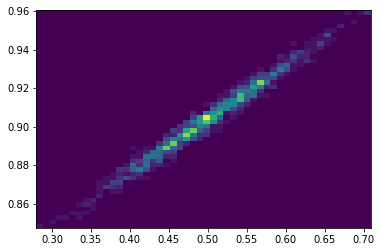

In [19]:
# first we plot the distribution of the noisy summaries
bins = 50
plt.hist2d(summaries_noise[:, 0], summaries_noise[:, 1], bins=bins);
print(summaries_noise[:, 0].std())
print(summaries_noise[:, 1].std())

0.01479192312853125
0.0041980232203730535


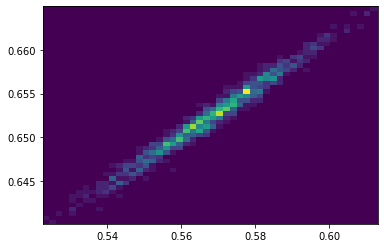

In [20]:
bins = 50
plt.hist2d(summaries_noise_kept[:, 0], summaries_noise_kept[:, 1], bins=bins);
print(summaries_noise_kept[:, 0].std())
print(summaries_noise_kept[:, 1].std())

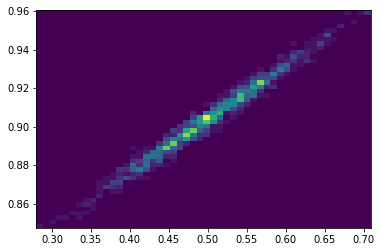

In [21]:
# first we plot the distribution of the noisy summaries
bins = 50
plt.hist2d(summaries_noise[:, 0], summaries_noise[:, 1], bins=bins);
plt.scatter(summary_obs[0, 0], summary_obs[0, 1]);

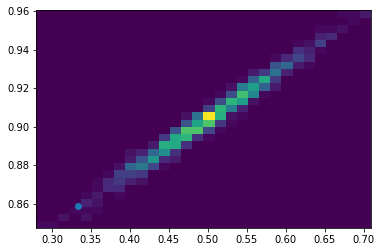

In [22]:
# we also check if the shift FN is within the summaries of the fiducial noisy data
bins = 30
plt.hist2d(summaries_noise[:, 0], summaries_noise[:, 1], bins=bins);
plt.scatter(summary_shift[0][0], summary_shift[0][1])

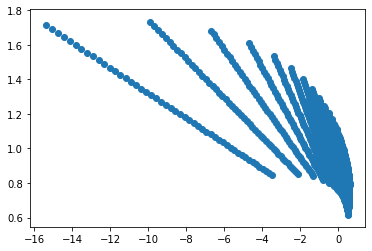

In [23]:
plt.scatter(summaries_posterior[:, 0], summaries_posterior[:, 1]);

# Gaussianisation of the latent space

At this stage, we finally need to set up the NF between the obtaines sample of summaries, in order to have the bijection to that space. We will use Inverse Autoregressive Flows (IAFs).

In [24]:
# we define a few variables here, and reset the graph
DTYPE=tf.float32
NP_DTYPE=np.float32
tf.reset_default_graph()
batch_size = 128
num_bijectors = 16

# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=summaries_noise.shape[0])
dataset = dataset.prefetch(3 * batch_size)
dataset = dataset.batch(batch_size)
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [25]:
# this is the distribution to match
#base_dist = tfd.Normal(loc=0.0, scale=1.0)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [26]:
# we define the flow here
bijectors = []
for i in range(num_bijectors):
    bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[1024, 1024]))))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [27]:
# this is the transformed distribution, i.e. the distribution of the summaries
dist = tfd.TransformedDistribution(
            distribution=base_dist,
            bijector=flow_bijector)

In [28]:
# optimisation
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

Instructions for updating:
Please use `layer.__call__` method instead.


0 2.3383048
500 -1.1640033
1000 -2.8575711
1500 -5.3778763


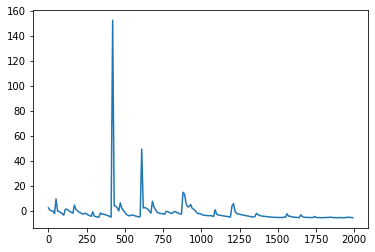

In [29]:
# and finally we train the NF as well
sess = tf.Session()
sess.run(tf.global_variables_initializer())
NUM_STEPS = 2000#int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 10 == 0:
        global_step.append(i)
        losses.append(np_loss)
        #g_losses.append(gl)
    if i % int(5e2) == 0:
        print(i, np_loss)
start = 0
plt.plot(global_step, losses[start:])

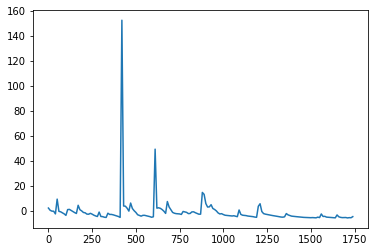

In [30]:
plt.plot(global_step[:175], losses[:175])

In [31]:
# now we need to look at samples which we inject in the flow to the Gaussian domain
# just to make sure the gaussianisation was successful

In [32]:
# we look at the flow injection, which corresponds to the inverse pass
x = x_samples
samples = [x]
names = [base_dist.name]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
    names.append(bijector.name)
samples_plot = [samples[0], samples[-1], base_dist.sample(128)]
names=['Latent', 'Mapped latent', 'Original Gaussian']

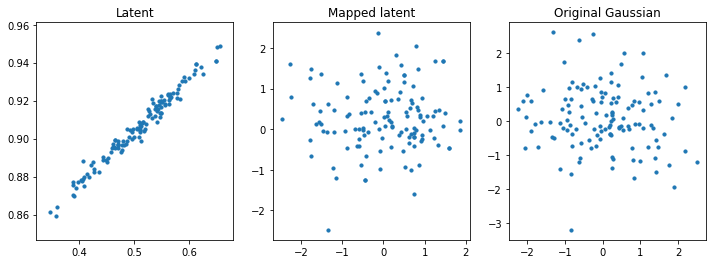

In [33]:
noise_flow = sess.run(samples_plot)
f, arr = plt.subplots(1, len(noise_flow), figsize=(4 * (len(noise_flow)), 4))
X0 = noise_flow[0]
for i in range(len(noise_flow)):
    X1 = noise_flow[i]
    arr[i].scatter(X1[:, 0], X1[:, 1], s=10)
    arr[i].set_title(names[i])

In [34]:
print(noise_flow[0][:, 0].mean())
print(noise_flow[0][:, 1].mean())
print(noise_flow[1][:, 0].mean())
print(noise_flow[1][:, 1].mean())
print(noise_flow[2][:, 0].mean())
print(noise_flow[2][:, 1].mean())

0.5077627
0.9061691
0.008953273
0.26282007
0.019088194
0.08812316


In [35]:
print(noise_flow[0][:, 0].std())
print(noise_flow[0][:, 1].std())
print(noise_flow[1][:, 0].std())
print(noise_flow[1][:, 1].std())
print(noise_flow[2][:, 0].std())
print(noise_flow[2][:, 1].std())

0.06776429
0.018800896
0.9701729
0.7829372
1.0424978
0.9231069


In [36]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summary_obs.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_obs = data_iterator.get_next()

In [37]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summaries_posterior.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n_sims)
dataset = dataset.batch(n_sims)
data_iterator = dataset.make_one_shot_iterator()
x_samples_posterior = data_iterator.get_next()

In [38]:
# we inject the shift as well
dataset = tf.data.Dataset.from_tensor_slices(summary_shift.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_shift = data_iterator.get_next()

In [39]:
# we inject the FN observation in the flow, since we need the fiducial one for the posterior evaluation
x = x_samples_shift
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
shift_flow_ = samples[-1]
shift = sess.run(shift_flow_)

In [40]:
shift[0]

array([-2.6376402,  0.3451718], dtype=float32)

In [41]:
# we inject the posterior points
x = x_samples_posterior
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
posterior_points_ = samples[-1]
posterior_points = sess.run(posterior_points_)

In [42]:
# check that there are no duplicates
posterior_points__ = list(np.reshape(posterior_points, [-1]))

import collections
print ([item for item, count in collections.Counter(posterior_points__).items() if count > 1])

[]


In [43]:
# we need to shift the posterior points as we want the mean to be captured, and they have fixed noise
posterior_points_mu = posterior_points - shift[0]

In [44]:
# finally, we try to evaluate the posterior
# we first inject the observation in the flow as well
x = x_samples_obs
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
observation_ = samples[-1]
compressed_obs = sess.run(observation_)

In [45]:
posterior_points.shape

(2500, 2)

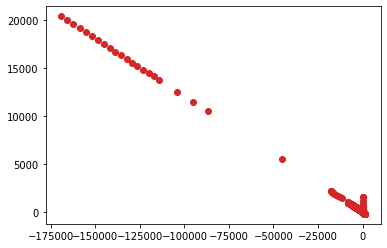

In [46]:
plt.scatter(noise_flow[1][:, 0], noise_flow[1][:, 1])
plt.scatter(compressed_obs[0][0], compressed_obs[0][1])
plt.scatter(shift[0][0], shift[0][1]);
plt.scatter(posterior_points_mu[:, 0], posterior_points_mu[:, 1]);

In [47]:
# finally we evaluate the likelihood
from scipy.stats import multivariate_normal as normal
likelihood_arr = np.zeros((n_sims, 3))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0], mean=mu, cov=np.eye(2))
    likelihood_arr[index, :] = q_prior[index, 0], q_prior[index, 1], like_value

In [48]:
likelihood_arr[:, 2] = likelihood_arr[:, 2]/likelihood_arr[:, 2].sum()

In [49]:
d_vec_obs_keep[0]

array([2.20988324e-09, 1.39308811e-09, 9.83102681e-10, 7.42816198e-10,
       5.86937767e-10, 4.78653885e-10, 3.99625846e-10, 3.39831272e-10,
       2.93242857e-10, 2.36417106e-10, 2.07638019e-10, 1.83943079e-10,
       1.64171592e-10, 1.47481596e-10, 1.33249374e-10, 1.21004155e-10,
       1.10340251e-10, 1.01109375e-10, 9.29526293e-11, 8.57481505e-11,
       7.93328652e-11, 7.36226805e-11, 6.84882937e-11, 6.38725126e-11,
       5.96953017e-11, 5.59091084e-11, 5.24510612e-11, 4.93051897e-11,
       4.64393545e-11, 4.37970253e-11, 4.13658119e-11, 3.91296830e-11,
       3.70586723e-11, 3.51430540e-11, 3.33683009e-11, 3.17122756e-11,
       3.01713136e-11, 2.87410911e-11, 2.74086747e-11, 2.61571732e-11,
       2.49833310e-11, 2.38843891e-11, 2.28527942e-11, 2.18789969e-11,
       2.09617494e-11, 2.01002327e-11, 1.92909451e-11, 1.85275014e-11,
       1.78026125e-11])

In [50]:
# we retrieve the real posterior here
# a few things that will be useful later on
from scipy.stats import gamma
ell = np.arange(2, lmax+1)
shape = mul_mode_fac*(2*ell+1)/2

likelihood_arr_true = np.zeros((n_bins*n_bins, 3))
index = 0

# and we evaluate the likelihood here
for i in xx:
    for j in yy:
        load = np.loadtxt(f'./power_spectra/power_spectrum_{i}_{j}.dat')
        cls = load[:, 1]
        scale = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        evaluation = gamma.pdf(x=d_vec_obs[0], a=shape, loc=0, scale=scale)  # the scipy gamma distribution has a slightly different definition than the numpy one
        likelihood = np.prod(evaluation/3e12)
        likelihood_arr_true[index, :] = i, j, likelihood
        index += 1
like_norm_true = np.sum(likelihood_arr_true[:, 2])
likelihood_arr_true[:, 2] = likelihood_arr_true[:, 2] / like_norm_true

In [51]:
omega_m_obs, S8_obs = q_obs[0], q_obs[1]

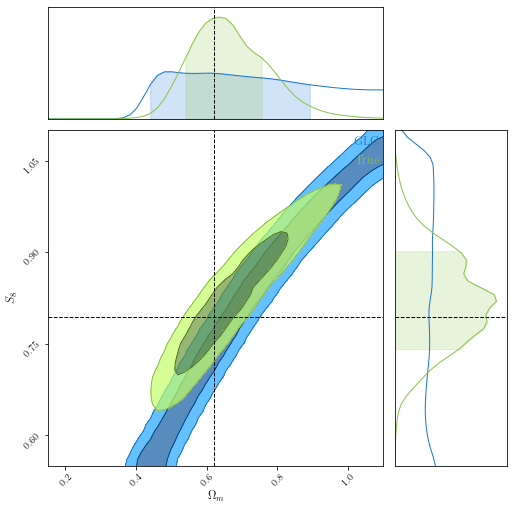

In [52]:
from chainconsumer import ChainConsumer
xs = likelihood_arr[:, 0]
ys = likelihood_arr[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat = likelihood_arr[:, 2]

xs_true = likelihood_arr_true[:, 0]
ys_true = likelihood_arr_true[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat_true = likelihood_arr_true[:, 2]

c = ChainConsumer()
c.add_chain([xs, ys], parameters=["$\Omega_m$", "$S_8$"], weights=pdf_flat, grid=True, name='GLC')
c.add_chain([xs_true, ys_true], parameters=["$\Omega_m$", "$S_8$"], weights=pdf_flat_true, grid=True, name='True')
c.configure(smooth=1.5) #Notice how smoothing changes the results!
fig = c.plotter.plot(truth=[omega_m_obs, S8_obs])

fig.set_size_inches(4.5 + fig.get_size_inches())  

In [ ]:
d_vec_obs

In [54]:
q_obs

[0.5, 0.9036961141150639]

In [128]:
# other tests to understand what is going wrong
# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise_kept.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n)
dataset = dataset.batch(n)
data_iterator = dataset.make_one_shot_iterator()
x_samples_kept = data_iterator.get_next()

x = x_samples_kept
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
kept = samples[-1]
noise_flow_kept = sess.run(kept)

#print(posterior_point_mu_kept[0][0])
print(noise_flow_kept.mean())
print(noise_flow_kept.std())

-216.83981
111.18058


In [129]:
idx = 2258
print(np.loadtxt('./power_spectra/parameters_rep_wider.txt')[obs_idx])
print(posterior_points_mu[idx], q_prior[idx])

[1.03665637 0.64321541]
[-104.88714 -321.91138] [1.02244898 0.63979592]


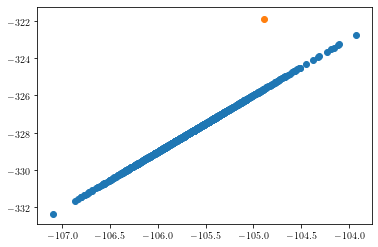

In [131]:
plt.scatter(noise_flow_kept[:, 0], noise_flow_kept[:, 1]);
plt.scatter(posterior_points_mu[idx][0], posterior_points_mu[idx][1]);

In [57]:
print(noise_flow_kept[:, 0].mean())
print(noise_flow_kept[:, 1].mean())

-72.33367
-60.11797


In [58]:
print(noise_flow_kept[:, 0].std())
print(noise_flow_kept[:, 1].std())

0.2729098
7.579063


In [80]:
def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

In [81]:
# we want to draw 68% confidence intervals here, and we start by
# finding the level corresponding to that
sorted_posterior = sorted(theo_post[:, 1], reverse=True)
# we should now start summing the elements in this sorted list,
# and stop when we reach the desired level, usually 68 or 95
req_level = 0.68
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
condition = np.where(theo_post[:, 1] >= rep_level, 1, -1)
try:
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0

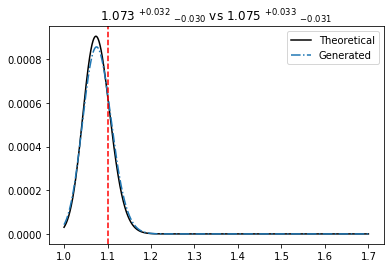

In [82]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
#plt.fill_between(theo_post[id1:id2+1, 0], theo_post[id1:id2+1, 1],  alpha=0.5, color='k')

# from the ML, with the corresponding error
# confidence levels of the generated one
sorted_posterior = sorted(likelihood_arr[:, 1], reverse=True)
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
try:
    condition = np.where(likelihood_arr[:, 1] >= rep_level, 1, -1)
    id1_gen, id2_gen = np.argwhere(np.diff(condition)).flatten()
except:
    id1_gen, id2_gen = 0, 0
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
#plt.fill_between(likelihood_arr[id1_gen:id2_gen+1, 0], likelihood_arr[id1_gen:id2_gen+1, 1], alpha=0.5, color='C0')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')
max_est = theo_post[np.argmax(theo_post[:, 1]), 0]
upp_bound = theo_post[id2, 0] - max_est
low_bound = max_est - theo_post[id1, 0]

max_est_gen = likelihood_arr[:, 0][np.argmax(likelihood_arr[:, 1])]
upp_bound_gen = likelihood_arr[:, 0][id2_gen] - max_est_gen
low_bound_gen = max_est_gen - likelihood_arr[:, 0][id1_gen]
plt.title(f'{max_est:.3f} $ ^{{ + {upp_bound:.3f} }}$ $ _{{ - {low_bound:.3f} }}$ vs {max_est_gen:.3f} $ ^{{ + {upp_bound_gen:.3f} }}$ $ _{{ - {low_bound_gen:.3f} }}$');
#plt.savefig('./posterior_1e3_nofill_diffprior.png')

In [44]:
# other tests to understand what is going wrong
# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise_kept.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n)
dataset = dataset.batch(n)
data_iterator = dataset.make_one_shot_iterator()
x_samples_kept = data_iterator.get_next()

x = x_samples_kept
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
kept = samples[-1]
noise_flow_kept = sess.run(kept)

#print(posterior_point_mu_kept[0][0])
print(noise_flow_kept.mean())
print(noise_flow_kept.std())

-5.8625674
0.9873675


In [29]:
# separate test for this case

In [13]:
def manual_gauss(data):
    return (data - summaries_noise.mean()) / summaries_noise.std()

noise_flow = manual_gauss(summaries_noise)
noise_flow_kept = manual_gauss(summaries_noise_kept)
compressed_obs = manual_gauss(summary_obs)
posterior_points = manual_gauss(summaries_posterior)
shift = manual_gauss(summary_shift)
posterior_points_mu = posterior_points  - shift
#shift_kept = manual_gauss(summary_shift_kept)
#posterior_point_mu_kept = shift_kept - shift

In [14]:
print(noise_flow.mean())
print(noise_flow.std())

-9.166001291305293e-16
0.9999999999999999


In [15]:
#print(posterior_point_mu_kept[0][0])
print(noise_flow_kept.mean())
print(noise_flow_kept.std())

0.7381241241648753
0.9892812301336827


In [16]:
shift 

array([[0.47775812]])

In [17]:
compressed_obs

array([[0.84920788]])

In [18]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_sims, 2))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_prior[index], like_value
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [19]:
import scipy.special as sps
theo_post = np.zeros((n_sims, 2))
for i, q in enumerate(q_prior):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

In [20]:
def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

In [21]:
# we want to draw 68% confidence intervals here, and we start by
# finding the level corresponding to that
sorted_posterior = sorted(theo_post[:, 1], reverse=True)
# we should now start summing the elements in this sorted list,
# and stop when we reach the desired level, usually 68 or 95
req_level = 0.68
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
condition = np.where(theo_post[:, 1] >= rep_level, 1, -1)
try:
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0

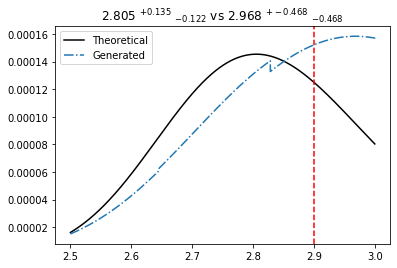

In [22]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
#plt.fill_between(theo_post[id1:id2+1, 0], theo_post[id1:id2+1, 1],  alpha=0.5, color='k')

# from the ML, with the corresponding error
# confidence levels of the generated one
sorted_posterior = sorted(likelihood_arr[:, 1], reverse=True)
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
try:
    condition = np.where(likelihood_arr[:, 1] >= rep_level, 1, -1)
    id1_gen, id2_gen = np.argwhere(np.diff(condition)).flatten()
except:
    id1_gen, id2_gen = 0, 0
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
#plt.fill_between(likelihood_arr[id1_gen:id2_gen+1, 0], likelihood_arr[id1_gen:id2_gen+1, 1], alpha=0.5, color='C0')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')
max_est = theo_post[np.argmax(theo_post[:, 1]), 0]
upp_bound = theo_post[id2, 0] - max_est
low_bound = max_est - theo_post[id1, 0]

max_est_gen = likelihood_arr[:, 0][np.argmax(likelihood_arr[:, 1])]
upp_bound_gen = likelihood_arr[:, 0][id2_gen] - max_est_gen
low_bound_gen = max_est_gen - likelihood_arr[:, 0][id1_gen]
plt.title(f'{max_est:.3f} $ ^{{ + {upp_bound:.3f} }}$ $ _{{ - {low_bound:.3f} }}$ vs {max_est_gen:.3f} $ ^{{ + {upp_bound_gen:.3f} }}$ $ _{{ - {low_bound_gen:.3f} }}$');

Automatically created module for IPython interactive environment


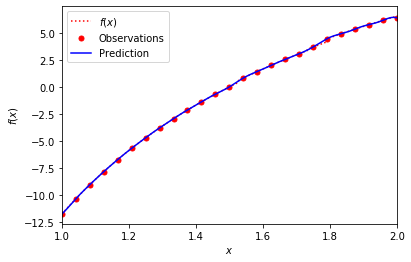

In [138]:
# we test the GP here, and its
# capability of interpolating between values
%matplotlib inline
print(__doc__)

# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    index, = np.where(q_prior == x)
    return posterior_points_mu[index]

# ----------------------------------------------------------------------
#  First the noiseless case
gp_points_number = 25
idx = np.arange(n_sims)
np.random.shuffle(idx)
idx = np.linspace(0, n_sims-1, gp_points_number, dtype=np.int64) #idx[:5]
X = np.atleast_2d(q_prior[idx]).T #np.atleast_2d(np.arange(10)).T

# Observations
y = posterior_points_mu[idx] #f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(1, 2, n_sims)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, np.take(posterior_points_mu, np.arange(n_sims)), 'r:', label=r'$f(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(1.0, 2)
#plt.ylim(-5, 10)
plt.legend(loc='upper left')
plt.show()

In [139]:
y_pred[342:346]

array([[-10.59598752],
       [-10.59251528],
       [-10.58904423],
       [-10.58557439]])

In [140]:
posterior_points_mu[342:346]

array([[-10.58457451],
       [-10.58128205],
       [-10.57799022],
       [-10.57469902]])

In [141]:
idx

array([   0,  416,  833, 1249, 1666, 2083, 2499, 2916, 3333, 3749, 4166,
       4582, 4999, 5416, 5832, 6249, 6666, 7082, 7499, 7915, 8332, 8749,
       9165, 9582, 9999], dtype=int64)

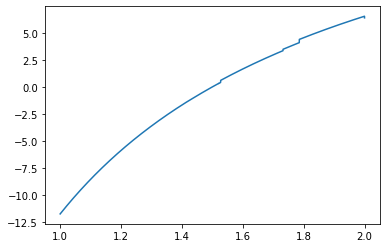

In [142]:
plt.plot(x, posterior_points_mu)

In [143]:
is_sorted = lambda a: np.all(a[:-1] <= a[1:])
is_sorted(posterior_points_mu)

False

In [144]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_sims, 2))
for index, mu in enumerate(y_pred):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_prior[index], like_value
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [145]:
import scipy.special as sps
theo_post = np.zeros((n_sims, 2))
for i, q in enumerate(q_prior):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

In [ ]:
def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

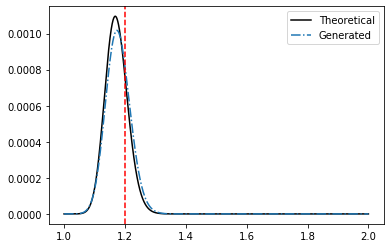

In [146]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')

# Posterior evaluation

After all we've done, we do have a tool that has gaussianised the likelihood. In fact, for a given parameter q, we can create an observation with fixed noise and feed it through the encoder+NF to get a point $y$. The likelihood is a unit Gaussian, with mean given by $\mu = y - z$, with $z$ the output of encoder+NF for the fiducial fixed noise realisation. In this sense, we only need to run 1 simulation per cosmological parameter.

A general observation, instead, is simply encoded and injected in the NF, thus getting the observed compressed data vector.

In order to check if we built a useful tool, we are going to calculate the posterior thus obtained. If this works, we can then build on top of this. But, as I expect, it does not work, well... we will need to re-think all of this.

In [34]:
# attempt to understand what is happening in this 2D case contour plot
# we retrieve the real posterior here
# a few things that will be useful later on
lmax = 50
n_vec = lmax-1
q_fid = [0.5, 0.7]
mul_mode_fac = 20 # factor multiplied to k and divided in theta to shrink error bars
n_bins = 50
xx = np.linspace(0.15, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)
yy = np.linspace(0.55, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)

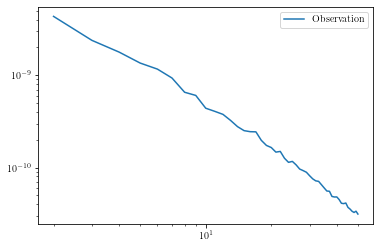

In [35]:
d_vec_obs = np.zeros((1, n_vec)) 
for index in range(1):
    load = np.loadtxt('./power_spectra/der_power_spectrum_0.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = mul_mode_fac*(2*ell+1)/2
        location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        single.append(np.random.gamma(shape, location))
    d_vec_obs[index] = single
#d_vec_obs = load[2:, 1]
d_vec_obs = np.reshape(d_vec_obs, [1, -1])

plt.loglog(np.arange(2, lmax+1), d_vec_obs[0], label='Observation')
plt.legend()
plt.show();

In [36]:
d_vec_obs

array([[4.34664988e-09, 2.39047696e-09, 1.78334184e-09, 1.35577334e-09,
        1.16596626e-09, 9.33333595e-10, 6.54320148e-10, 6.04707702e-10,
        4.39468625e-10, 4.06463851e-10, 3.76861124e-10, 3.24270403e-10,
        2.77359643e-10, 2.51082776e-10, 2.44656719e-10, 2.43664899e-10,
        1.97116921e-10, 1.73618603e-10, 1.64712158e-10, 1.46892517e-10,
        1.49450395e-10, 1.26037789e-10, 1.13807470e-10, 1.16514210e-10,
        1.06932035e-10, 9.63195353e-11, 9.26384744e-11, 8.88810144e-11,
        8.14928936e-11, 7.54021932e-11, 7.17252870e-11, 7.07659600e-11,
        6.51502269e-11, 6.00823299e-11, 5.56500755e-11, 5.52856292e-11,
        4.85883737e-11, 4.79248303e-11, 4.79847193e-11, 4.49360056e-11,
        4.09700798e-11, 4.06348387e-11, 4.12392032e-11, 3.70099882e-11,
        3.54715035e-11, 3.35701577e-11, 3.25866567e-11, 3.36375673e-11,
        3.13070167e-11]])

In [37]:
ell = np.arange(2, lmax+1)
shape = mul_mode_fac*(2*ell+1)/2

likelihood_arr_true = np.zeros((n_bins*n_bins, 3))
index = 0

# and we evaluate the likelihood here
for i in xx:
    for j in yy:
        load = np.loadtxt(f'./power_spectra/power_spectrum_{i}_{j}.dat')
        cls = load[:, 1]
        scale = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        evaluation = gamma.pdf(x=d_vec_obs[0], a=shape, loc=0, scale=scale)  # the scipy gamma distribution has a slightly different definition than the numpy one
        likelihood = np.prod(evaluation/3e12)
        #print(likelihood)
        likelihood_arr_true[index, :] = i, j, likelihood
        index += 1
like_norm_true = np.sum(likelihood_arr_true[:, 2])
likelihood_arr_true[:, 2] = likelihood_arr_true[:, 2] / like_norm_true

In [38]:
q_obs = [0.5, 0.7]  # this is Omega_m, sigma_8
omega_m_obs, S8_obs = q_obs[0], q_obs[1]*np.sqrt(q_obs[0]/0.3)

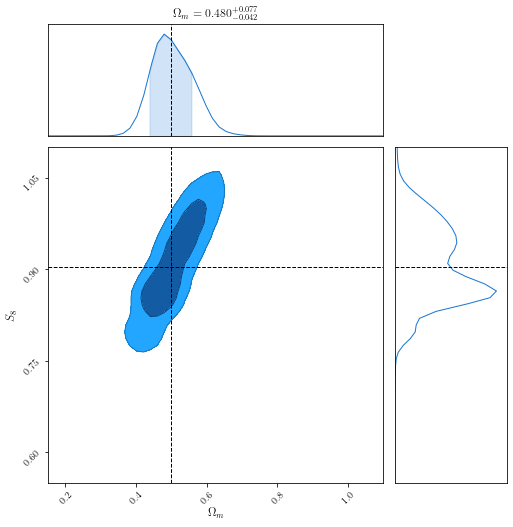

In [40]:
from chainconsumer import ChainConsumer

xs_true = likelihood_arr_true[:, 0]
ys_true = likelihood_arr_true[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat_true = likelihood_arr_true[:, 2]

c = ChainConsumer()
c.add_chain([xs_true, ys_true], parameters=["$\Omega_m$", "$S_8$"], weights=pdf_flat_true, grid=True, name='True')
c.configure(smooth=1.5)  # Notice how smoothing changes the results!
fig = c.plotter.plot(truth=[omega_m_obs, S8_obs])

fig.set_size_inches(4.5 + fig.get_size_inches())  